In [1]:
!pip install pandas-plink limix-lmm


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from pandas_plink import read_plink
from limix_lmm import LMM
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
import seaborn as sns

In [3]:
import pdb
import pylab as plt
import os

In [4]:
# --- Compatibility patch for SciPy deprecations (Colab / Python 3.12) ---
# Some older packages such as `limix` still reference deprecated SciPy functions
# like `scipy.log`, `scipy.exp`, and `scipy.sqrt`. These were removed starting from
# SciPy 1.12 (2024) and are no longer available in recent Python environments.
#
# On Google Colab, the default Python version is currently 3.12, which only supports
# SciPy >= 1.12. Older versions of SciPy (<= 1.10.1), which still provided these
# functions, cannot be installed because they require Python < 3.12.
#
# Therefore, we manually alias these missing functions to their NumPy equivalents.
# This "monkey patch" allows legacy code (e.g., `limix`) to run under the current
# Colab setup without downgrading Python or SciPy.
# -----------------------------------------------------------------------------

import scipy
import scipy.stats as st

if not hasattr(scipy, 'dot'):
    scipy.dot = np.dot
if not hasattr(scipy, 'einsum'):
    scipy.einsum = np.einsum
if not hasattr(scipy, 'log'):
    scipy.log = np.log
if not hasattr(scipy, 'sign'):
    scipy.sign = np.sign
if not hasattr(scipy, 'sqrt'):
    scipy.sqrt = np.sqrt

plink --bfile C:\Users\david\PycharmProjects\GoBi\gobi_gwas\ALL.chr22_GRCh38.genotypes.20170504\ALL.chr22_GRCh38.genotypes.20170504 --snps-only --geno 0.02 --maf 0.01 --hwe 1e-6 --make-bed --out C:\Users\david\PycharmProjects\GoBi\gobi_gwas\david\data\qc\chr22_step1_common

plink --bfile C:\Users\david\PycharmProjects\GoBi\gobi_gwas\david\data\qc\chr22_step1_common --list-duplicate-vars ids-only suppress-first --out C:\Users\david\PycharmProjects\GoBi\gobi_gwas\david\data\qc\dupcheck

wc -l C:\Users\david\PycharmProjects\GoBi\gobi_gwas\david\data\qc\dupcheck.dupvar

plink --bfile C:\Users\david\PycharmProjects\GoBi\gobi_gwas\david\data\qc\chr22_step1_common --exclude C:\Users\david\PycharmProjects\GoBi\gobi_gwas\david\data\qc\dupcheck.dupvar --make-bed --out C:\Users\david\PycharmProjects\GoBi\gobi_gwas\david\data\qc\chr22_step2_nodup

plink --bfile C:\Users\david\PycharmProjects\GoBi\gobi_gwas\david\data\qc\chr22_step2_nodup --mind 0.02 --make-bed --out C:\Users\david\PycharmProjects\GoBi\gobi_gwas\david\data\qc\chr22_step3_sampleqc

In [9]:
# load genetic data
bfile = 'data/final/chr22_step3_sampleqc'
bim, fam, G = read_plink(bfile)





Mapping files:   0%|          | 0/3 [00:00<?, ?it/s]



Mapping files:   0%|          | 0/3 [00:37<?, ?it/s]




Mapping files: 100%|██████████| 3/3 [00:00<00:00,  6.79it/s]
C:\Users\david\PycharmProjects\GoBi\gobi_gwas\.venv\Lib\site-packages\pandera\_pandas_deprecated.py:146: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnin

In [10]:
def extract_region(bim, G, chrom, start, end):
    I1 = bim['chrom'] == str(chrom)
    I2 = bim['pos'] > start
    I3 = bim['pos'] < end
    Ikeep = I1 * I2 * I3
    bim = bim.loc[Ikeep].copy()
    G = G[bim['i'].values]
    bim['i'] = np.arange(len(bim))
    return bim, G

In [11]:
def subset_individuals(fam, G, keep_idxs):
    fam = fam.iloc[keep_idxs]
    G = G[:, keep_idxs]
    return bim, G

In [ ]:
# extract region
#chrom = 22
#start = 30797531
#size = 100000
#bimr, Gr = extract_region(bim, Gs, chrom, start, start + size)

In [12]:
X_real = G.compute().T

In [13]:
def simulate_pheno(X, idx_caus, var_expl, direction=None):
    # Ensure that the number of causal variant indices matches the number of variances explained.
    assert len(idx_caus) == len(var_expl)

    # If no direction is provided, randomly assign a positive or negative direction for each causal variant.
    if direction is None:
        direction = 2. * (np.random.rand(len(idx_caus)) > 0.5) - 1.
    # Ensure that the number of directions matches the number of causal variant indices.
    assert len(idx_caus) == len(direction)

    # Compute the remaining variance after accounting for the variance explained by the causal variants.
    ve = 1 - var_expl.sum()
    # Ensure that the total variance explained by causal variants is less than 1.
    assert ve > 0, 'sum(var_expl) should be < 1'

    # Compute the effect sizes for the causal variants based on the variance they explain and their direction.
    beta = np.sqrt(var_expl) * direction

    # Extract the columns of X corresponding to the causal variants and standardize them.
    Xc = X[:, idx_caus]
    Xc = (Xc - Xc.mean(0)) / Xc.std(0)

    # Compute the genetic component of the phenotype.
    yg = Xc.dot(beta)[:, None]
    # Compute the noise component of the phenotype.
    yn = np.sqrt(ve) * np.random.randn(X.shape[0], 1)

    # Sum the genetic and noise components to get the simulated phenotype.
    y = yg + yn

    # Initialize the real effect sizes for all variants in X as zeros.
    beta_real = np.zeros(X.shape[1])
    # Update the real effect sizes for the causal variants.
    beta_real[idx_caus] = beta

    # Standardize the phenotypic values to have mean 0 and standard deviation 1.
    ystd = y.std()
    y = (y - y.mean()) / ystd
    # Adjust the real effect sizes accordingly after standardizing y.
    beta_real = beta_real / ystd

    return y, beta_real

In [14]:
def qq_plot(ax, p_values, idx_caus):
    """
    Create a QQ plot given a list of p-values.

    Parameters:
    - p_values: list of p-values
    - figsize: size of the plot
    - title: title for the plot
    """

    # Sort p-values
    p_values = np.array(p_values).flatten()
    idx_caus = np.array(idx_caus).flatten()
    sorted_idx = np.argsort(p_values)
    observed = -np.log10(p_values[sorted_idx])
    expected = -np.log10(np.arange(1, len(p_values) + 1) / (len(p_values) + 2))

    # Create the QQ plot
    plt.scatter(expected, observed, marker='.', label="Non-causal")
    caus_in_sorted = np.argwhere(np.isin(sorted_idx, idx_caus)).flatten()
    plt.scatter(expected[caus_in_sorted], observed[caus_in_sorted], color='red', marker='o', s=20, label='Causal')
    plt.plot([0, max(expected)], [0, max(expected)], color='red', linestyle='--')
    plt.xlabel('Expected -log10(P-value)')
    plt.ylabel('Observed -log10(P-value)')
    plt.legend()

In [15]:
# Generate phenotype
rng = np.random.default_rng(42)
n_causal = 100
idx_caus = rng.choice(X_real.shape[1], size=n_causal)
h2 = 0.6
var_expl = np.full(n_causal, h2 / n_causal)
y, beta_real = simulate_pheno(X_real, idx_caus, var_expl)

In [16]:
# Perform genetic association testing
F = np.ones_like(y)
lmm = LMM(y, F)
lmm.process(X_real)
pv = lmm.getPv()
beta = lmm.getBetaSNP()
beta_ste = lmm.getBetaSNPste()

In [19]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test = train_test_split(X_real, test_size=0.3, random_state=42)

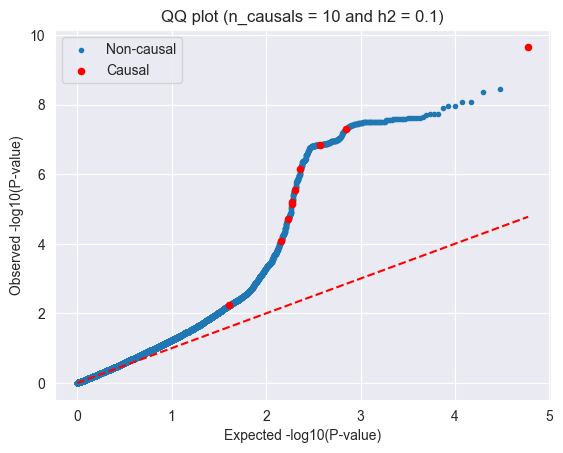

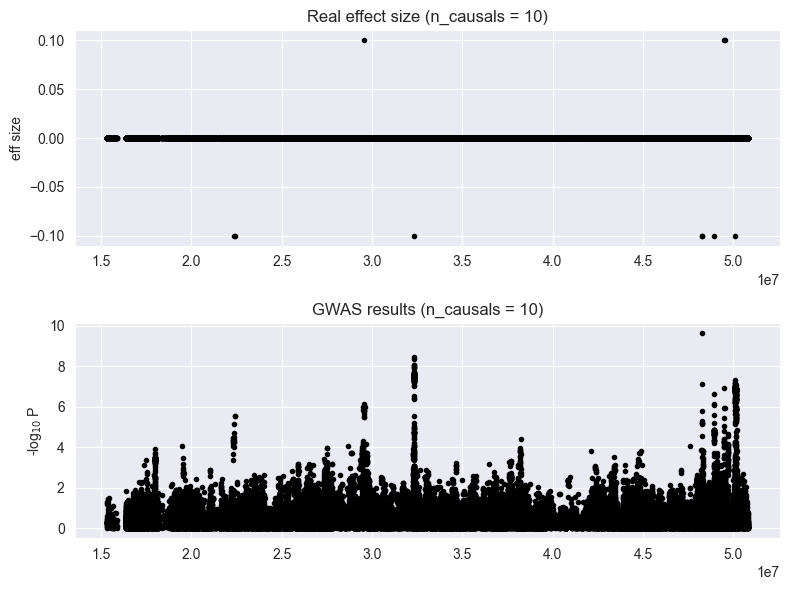

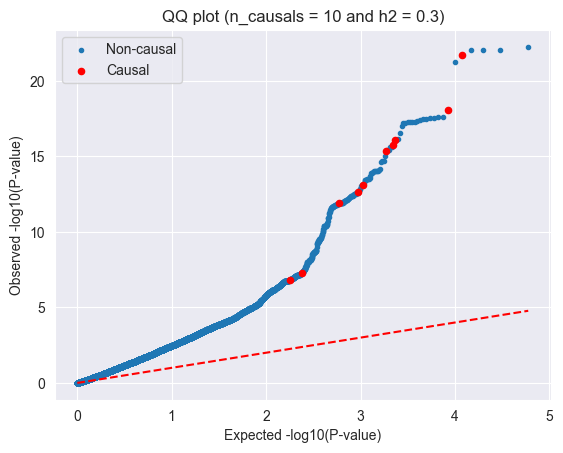

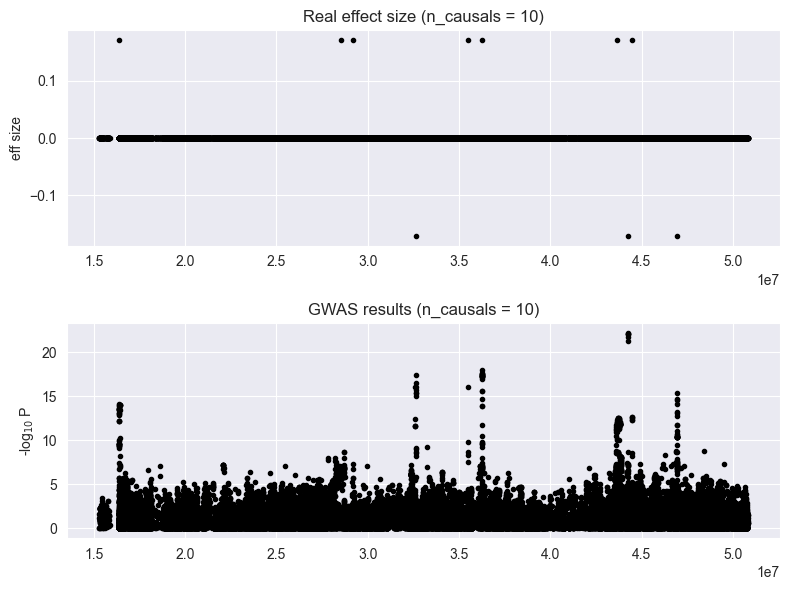

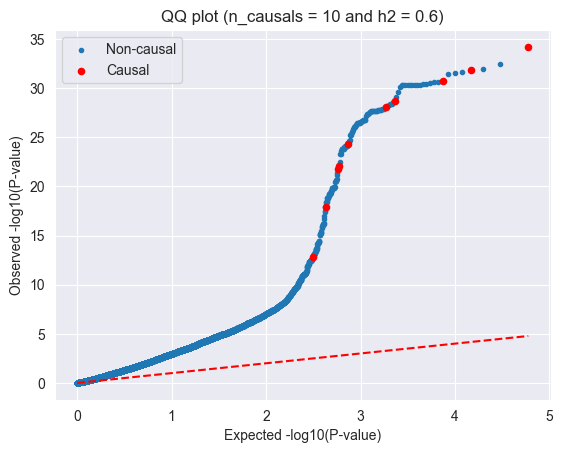

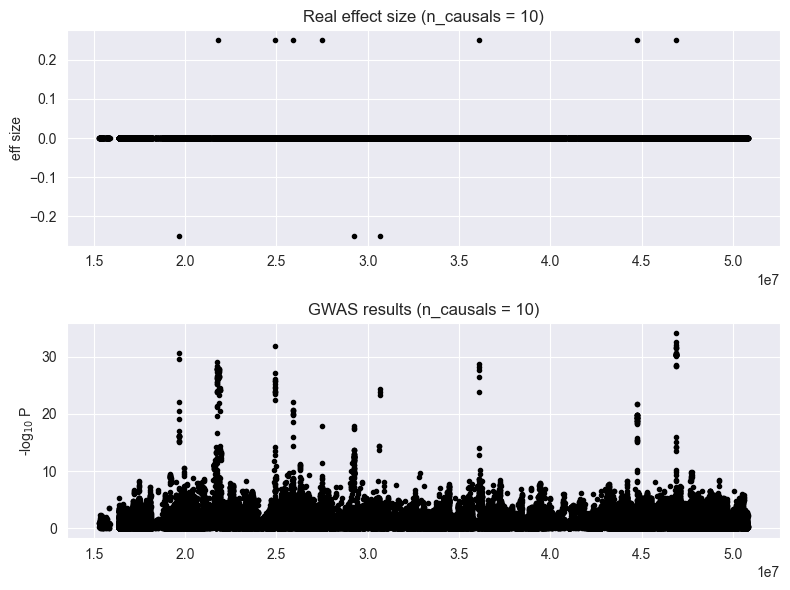

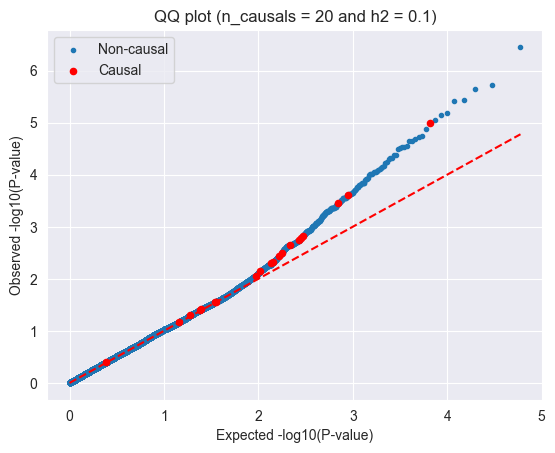

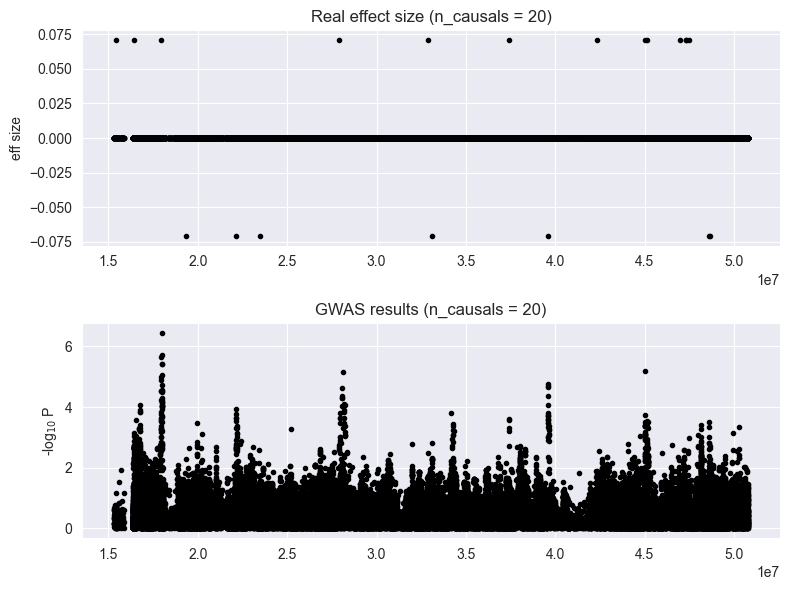

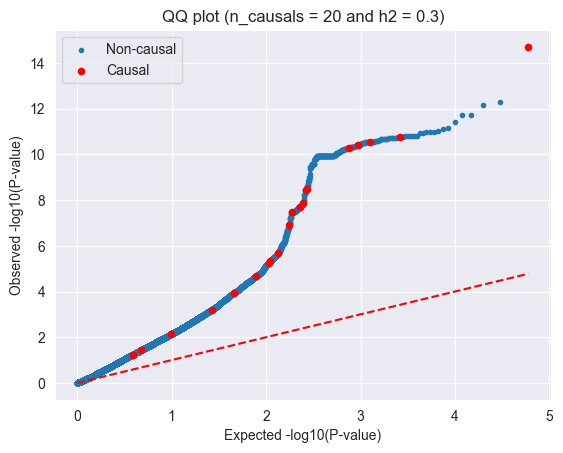

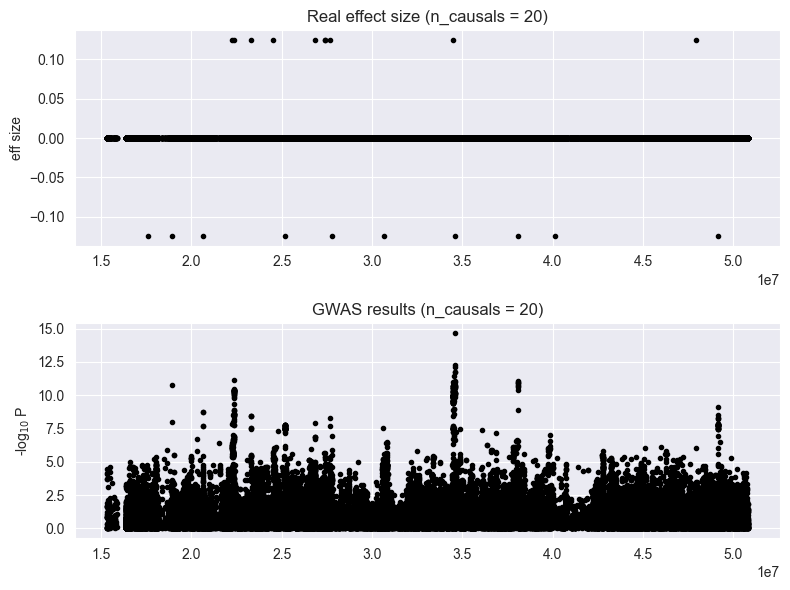

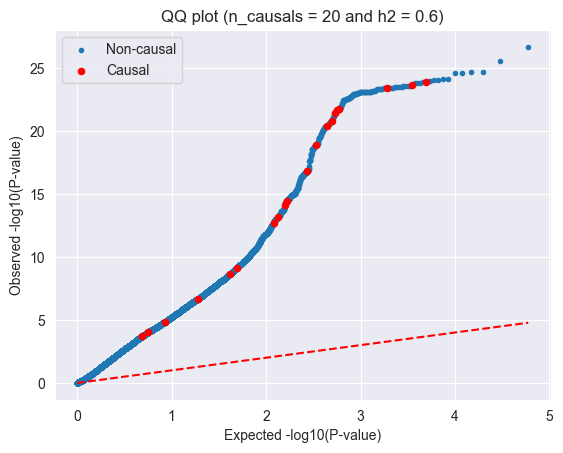

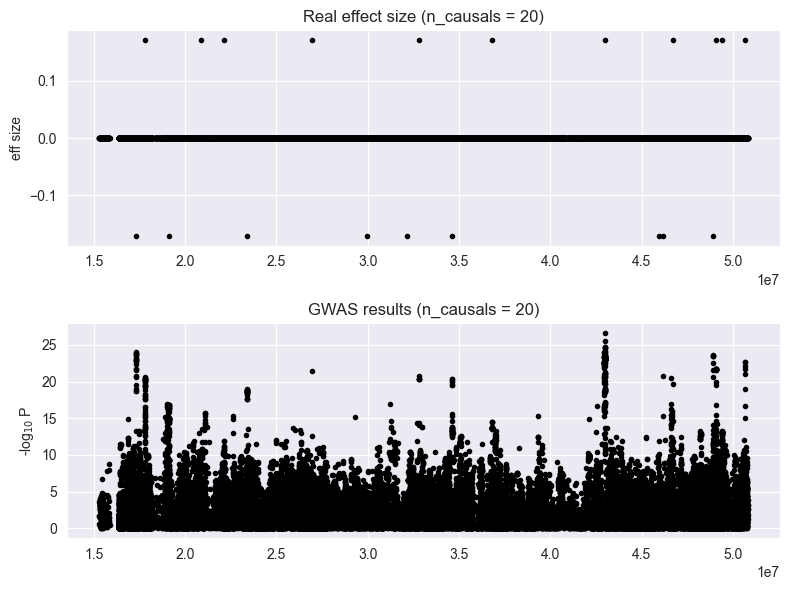

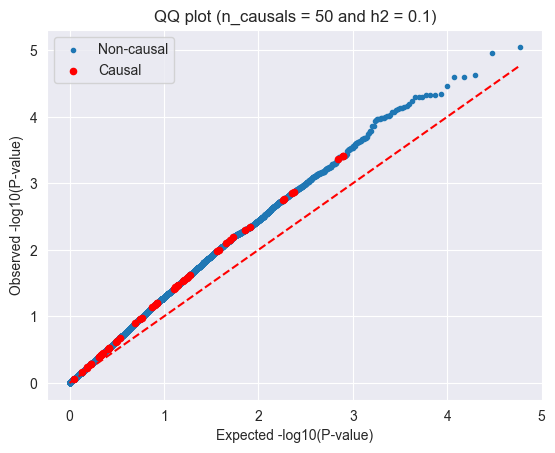

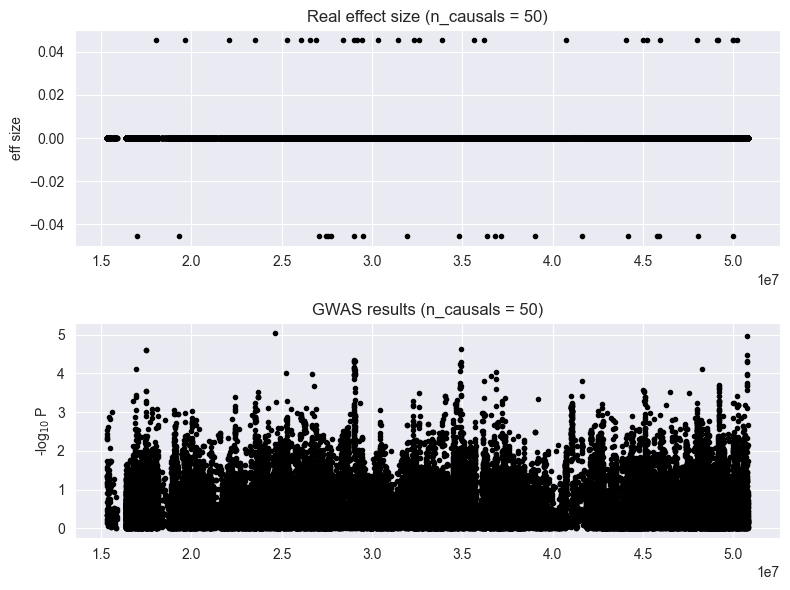

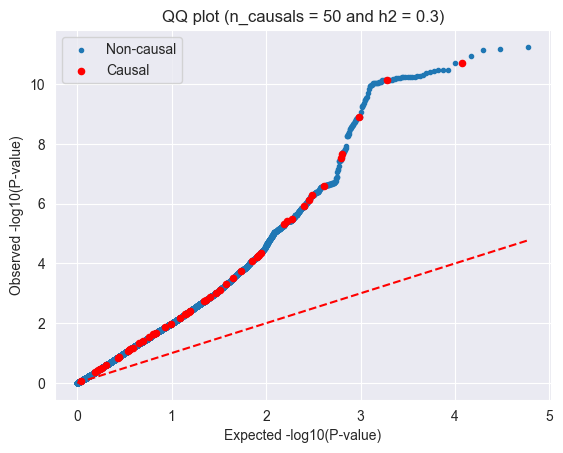

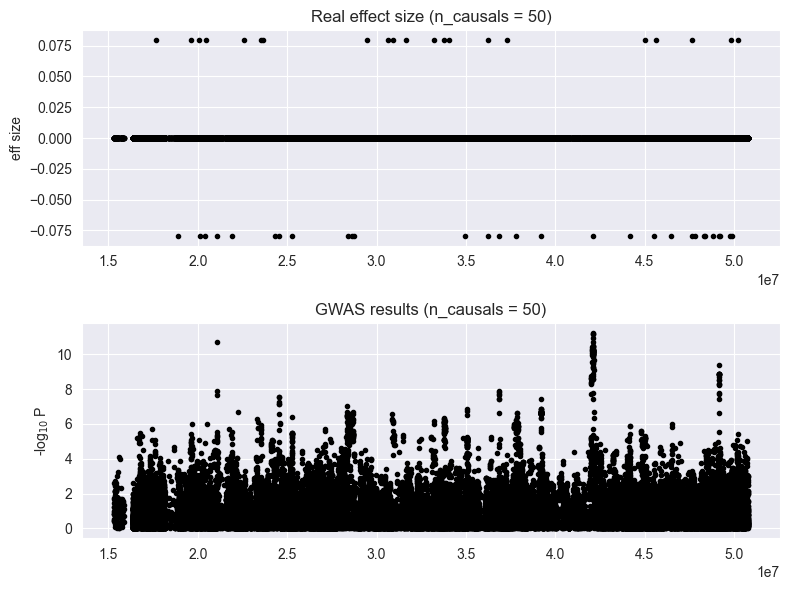

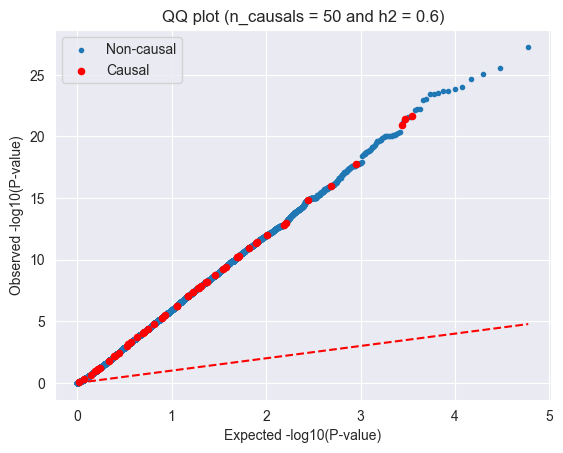

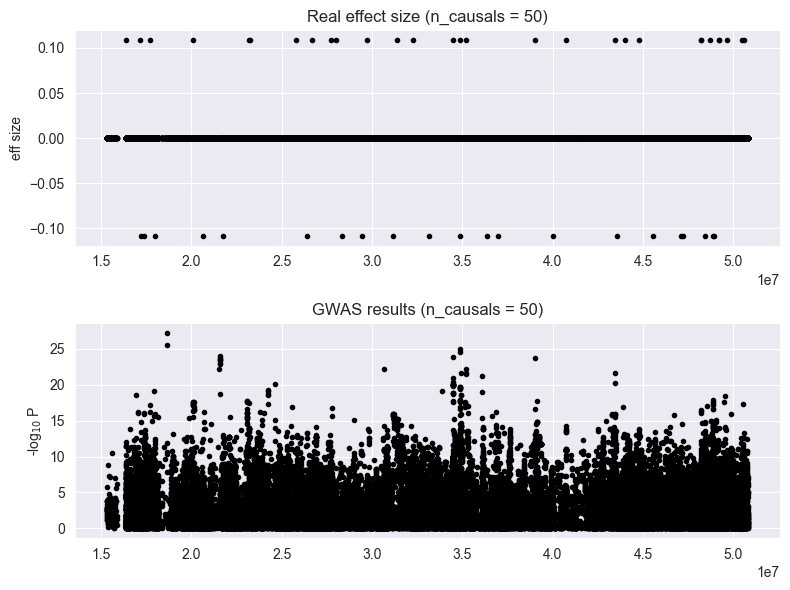

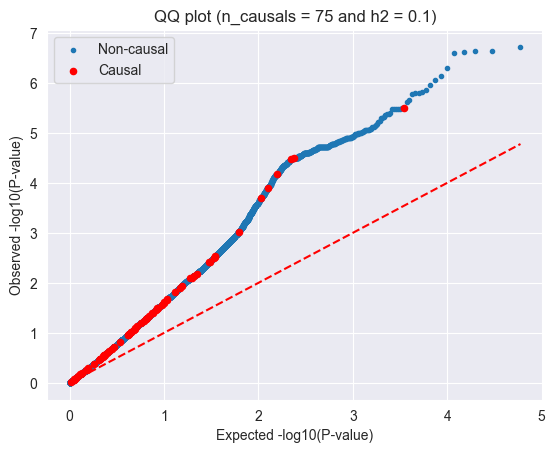

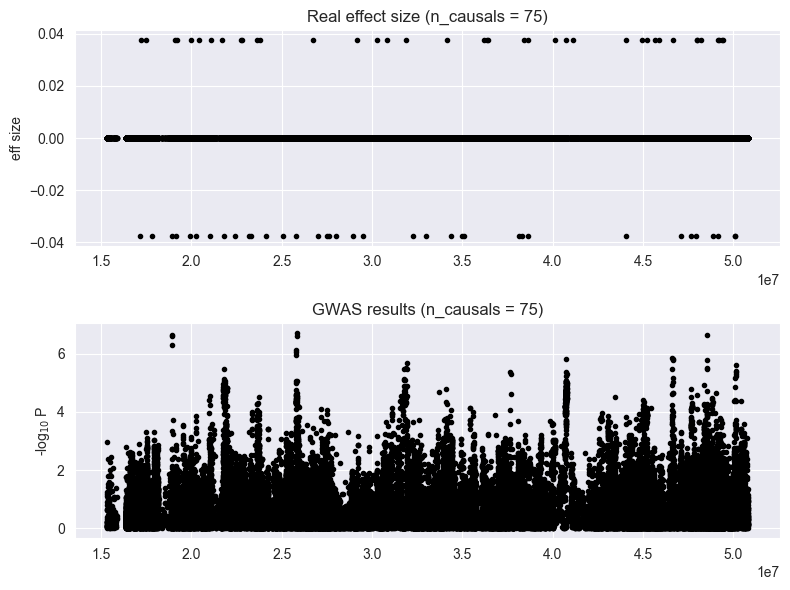

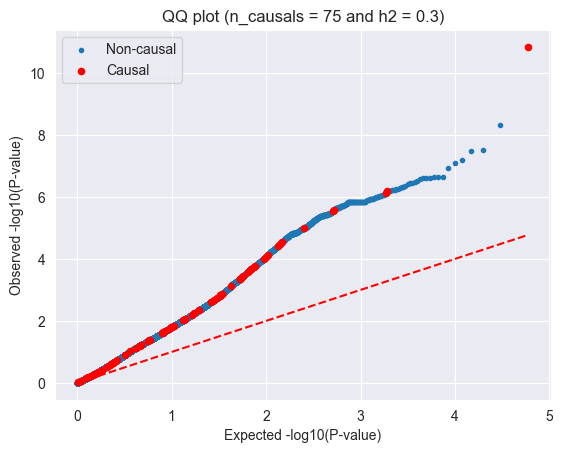

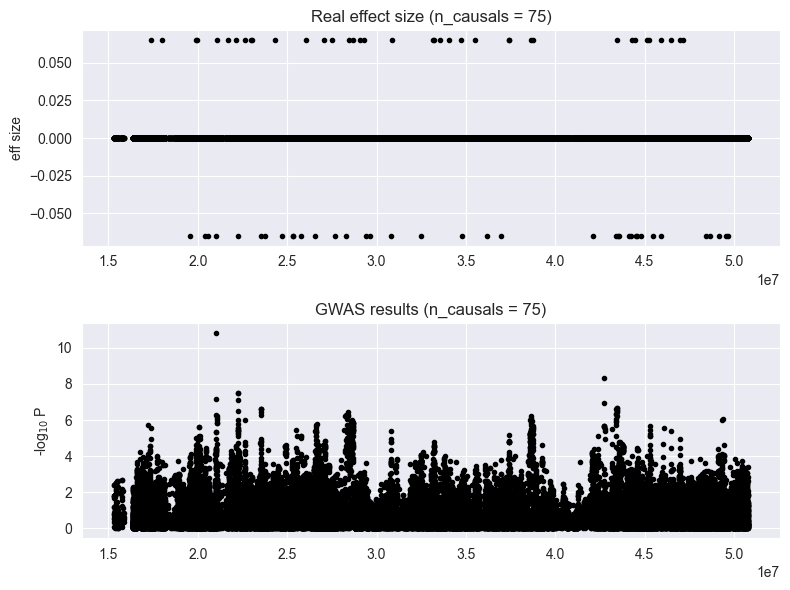

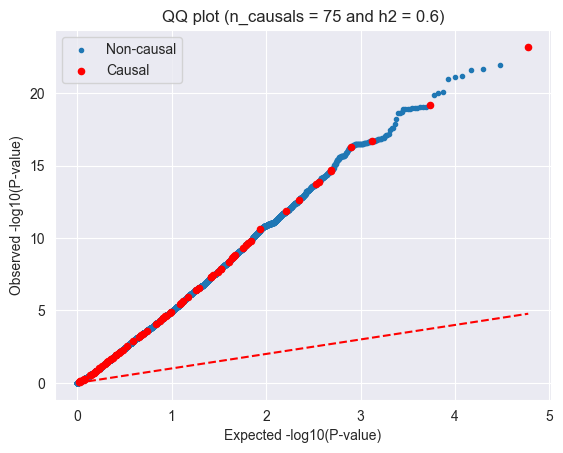

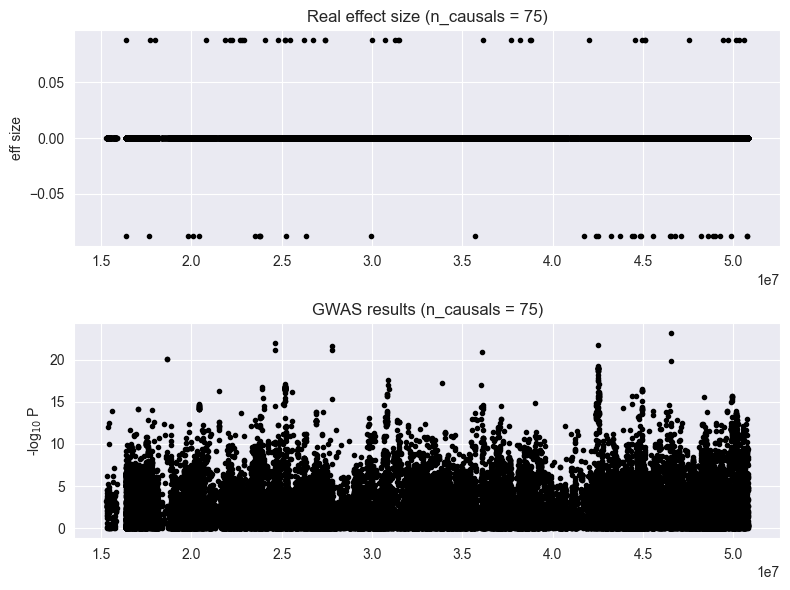

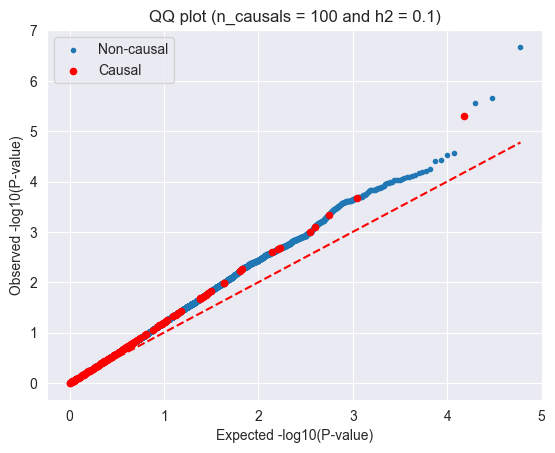

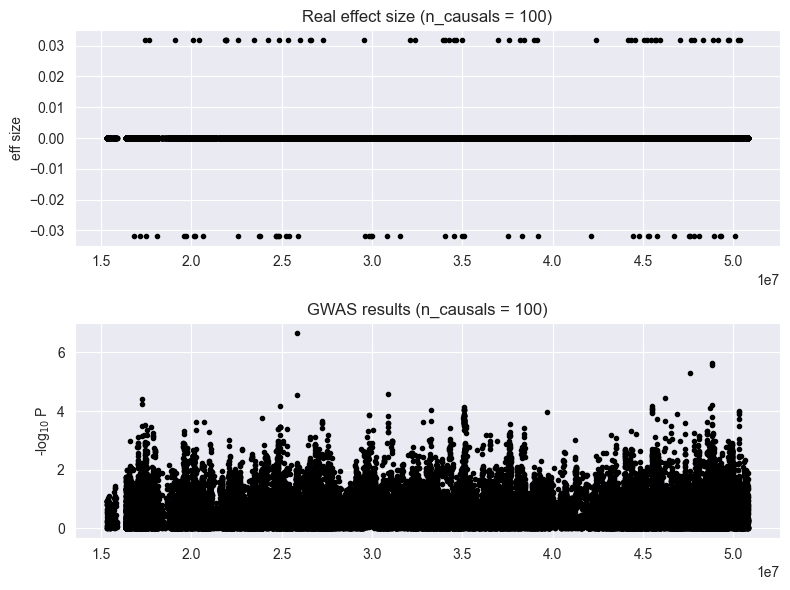

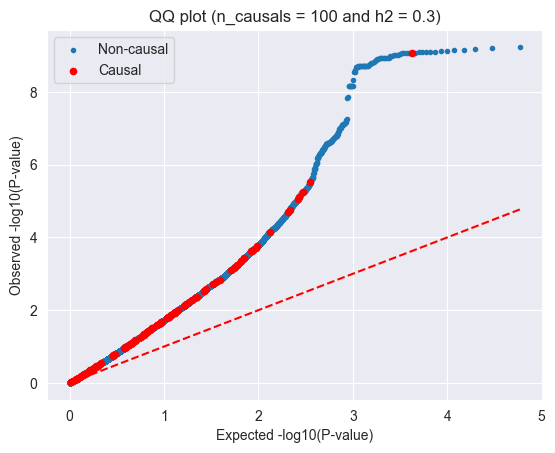

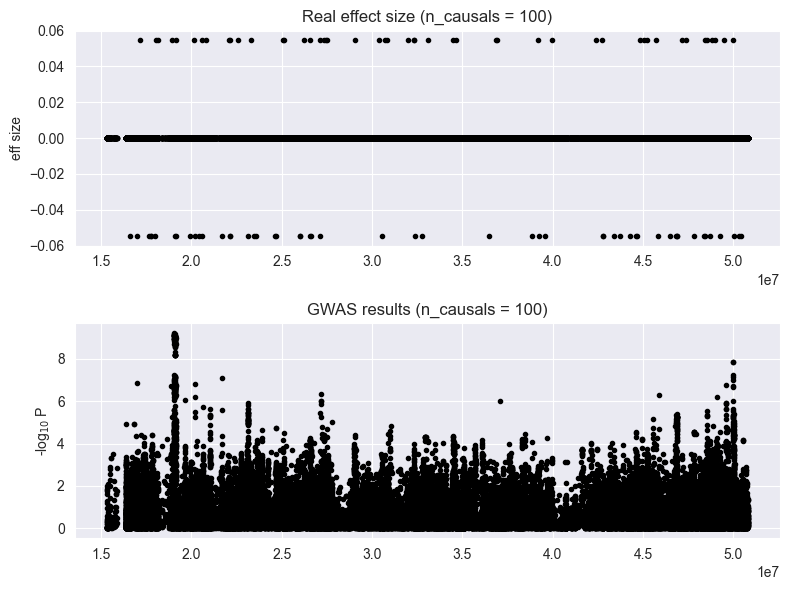

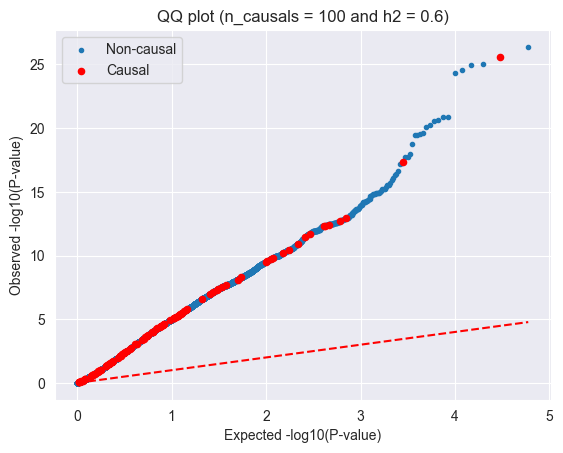

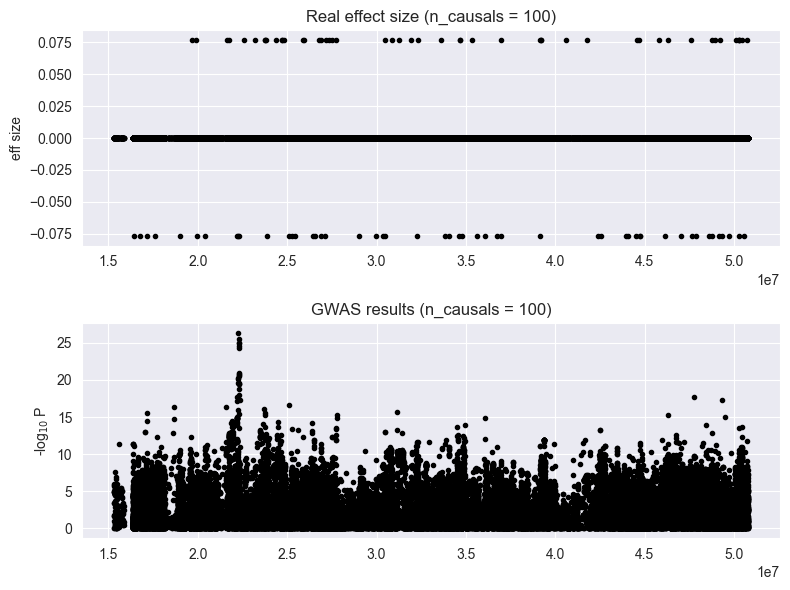

In [23]:
n_causals = [10,20,50,75,100]
h2s = [0.1,0.3,0.6]
for n_c in n_causals:
    for n_h2 in h2s:
      idx_caus = rng.choice(X_real.shape[1], size=n_c, replace=False)
      var_expl = np.full(n_c, n_h2 / n_c)
      y, beta_real = simulate_pheno(X_real, idx_caus, var_expl)
      X_train, X_test, y_train, y_test = train_test_split(X_real, y, test_size=0.3, random_state=42)
      F = np.ones_like(y_train)
      lmm = LMM(y_train, F)
      lmm.process(X_train)
      pv = lmm.getPv()
      beta = lmm.getBetaSNP()
      beta_ste = lmm.getBetaSNPste()
      qq_plot(None,pv, idx_caus)
      plt.title(f"QQ plot (n_causals = {n_c} and h2 = {n_h2})")
      plt.show()
      x = bim['pos'].values
      plt.figure(figsize=(8,6))
      plt.subplot(211)
      plt.title(f'Real effect size (n_causals = {n_c})')
      plt.plot(x, beta_real, '.k')
      plt.ylabel('eff size')
      plt.subplot(212)
      plt.title(f'GWAS results (n_causals = {n_c})')
      plt.plot(x, -np.log10(pv), '.k')
      plt.ylabel('-log$_{10}$ P')
      plt.tight_layout()
      plt.show()

In [24]:
gwas_df = pd.DataFrame({
    'CHR': bim['chrom'],
    'SNP': bim['snp'],
    'BP': bim['pos'],
    'P': pv
})
gwas_df.to_csv("gwas_results.txt", sep="\t", index=False)

plink --bfile C:\Users\david\PycharmProjects\GoBi\gobi_gwas\david\data\qc\chr22_step3_sampleqc --clump C:\Users\david\PycharmProjects\GoBi\gobi_gwas\david\gwas_results.txt --clump-r2 0.1 --out C:\Users\david\PycharmProjects\GoBi\gobi_gwas\david\data\final\chr22_step3_clumped

In [30]:
clumped = pd.read_csv(r"C:\Users\david\PycharmProjects\GoBi\gobi_gwas\david\data\final\chr22_step3_clumped.clumped", sep=r'\s+'
)

selected_snps = clumped['SNP'].values

In [31]:
snp_ids = bim['snp'].values  # from full dataset

# Boolean mask of selected SNPs
mask = np.isin(snp_ids, selected_snps)

# Subset training and test genotypes
X_train_sel = X_train[:, mask]
X_test_sel  = X_test[:, mask]

# Beta values from LMM GWAS on training
beta_sel = beta[mask]

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

In [33]:
# Train linear model
model = LinearRegression(fit_intercept=False)  # PRS-style: no intercept
model.fit(X_train_sel, y_train)

# Predictions
y_pred_test = model.predict(X_test_sel)

# Evaluate
r2 = r2_score(y_test, y_pred_test)
rho, _ = spearmanr(y_test, y_pred_test)

print("R²:", r2)
print("Spearman r:", rho)

R²: -1.7457957079233157
Spearman r: 0.24892858517484018
